# Table of Contents
 <p><div class="lev1"><a href="#Look-at-vertical-mass-flux"><span class="toc-item-num">1&nbsp;&nbsp;</span>Look at vertical mass flux</a></div>

Modules

In [9]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from mpl_toolkits.basemap import Basemap
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from scipy import stats
from netCDF4 import Dataset
from math import *
import glob
import string
import re
from datetime import date, time, datetime
from pprint import pprint
import sys,os
import csv
import pandas as pd
import pickle


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Paths

In [10]:
# Add ../functions to system path
currentpath = %pwd
currentpath = str(currentpath)
##-- In a python script do the following instead:
##-- currentpath = os.path.dirname(os.path.realpath(__file__))
sys.path.insert(0,currentpath[:currentpath.rfind('/')+1]+'functions')

## Fixed data files input directory
inputdir = '/Users/bfildier/Data/preprocessed'
inputdir_fx = '/Users/bfildier/Data/preprocessed/allExperiments/fx'
## Dataframe input directory
# resultdir = os.path.join(os.path.dirname(currentpath),'results')
resultdir = os.path.join(os.path.dirname(currentpath),'results/fullResults')
## Maps (2D tropical data files) input directory
inputdir_maps = os.path.join(os.path.dirname(currentpath),'inputs/forMaps')

##-- Output directories --##
## Figures
figdir = os.path.join(os.path.dirname(currentpath),'figures/fullResults')


Own modules and functions

In [11]:
from importingData import *
from extremeScaling import *
from thermodynamics import *
from thermo_funcs import *
from thermo_constants import *

Additional functions

In [12]:
###--- Functions ---### 

## Importing the results into directories of dataframes
def getStatDataFrame(stat,compsets,experiments,subsets,resultdir):
    
    """Import data frames in the for of embedded dictionaries.
    Output can be called as such: result[compset][experiment][subset]
    """
    
    stats_ok = ("pr_quantile_IL","pr_density_IL","pr_jointDensity_IL",
                "var2D_mean","var2D_meanAtQ",
                "var3D_meanProfile","var3D_meanProfileAtQ")
    df = {}
    if stat in stats_ok:
        for compset in compsets:
            df[compset] = {}
            for experiment in experiments:
                df[compset][experiment] = {}
                for subset in subsets:
                    csvfile = "%s_%s_%s_%s.csv"%(stat,compset,experiment,subset)
                    if stat in ("var2D_meanAtQ","var3D_meanProfileAtQ","pr_jointDensity_IL"):
                        df[compset][experiment][subset] = pd.read_csv(os.path.join(resultdir,csvfile),
                                                                      header=[0,1,2], skipinitialspace=True)
#                     elif stat == "pr_jointDensity_IL":
#                         df_jd = pd.read_csv(os.path.join(resultdir,csvfile))
#                         df_jd = df_jd.set_index(df_jd.columns[0])
#                         df[compset][experiment][subset] = df_jd
                    else:
                        df[compset][experiment][subset] = pd.read_csv(os.path.join(resultdir,csvfile))
    else:
        print "Warning: file handle not known."
        print "Should be one of the following:",stats_ok
    return df


## Get vertical profiles for plotting
def getAllProfiles(varids,pr_id,Q_id,df_mean,df_prof,computeP):
    
    ps_id, t_id, q_id, relhum_id, omega_id, w_id = varids
        
    ## Get surface values
    pres_s = df_mean[ps_id][pr_id][Q_id][0]
        
    if pr_id == "PRECT":

        ## Get existing profiles
        temp = df_prof[t_id][pr_id][Q_id]
        omega = df_prof[omega_id][pr_id][Q_id]
        relhum = df_prof[relhum_id][pr_id][Q_id]
        spechum = df_prof[q_id][pr_id][Q_id]
        
        ## Compute missing profiles
        pres = computeP(pres_s)
        rho = airDensity(temp,pres,spechum)
        wspeed = np.divide(omega,-g*rho)
    
    else:    # CRM_PREC_IXX
        
        ## Get existing profiles
        temp = np.flipud(df_prof[t_id][pr_id][Q_id])
        wspeed = np.flipud(df_prof[w_id][pr_id][Q_id])
        
        ## Compute missing profiles
        pres = computeP(pres_s)
        
        #         spechum = np.flipud(df_prof[q_id][pr_id][Q_id])
        spechum = df_prof[q_id][pr_id][Q_id]
        
        rho = airDensity(temp,pres,spechum)
        omega = np.multiply(wspeed,-g*rho)
        relhum = np.array([np.nan]*pres.size)
        
    ## Store all profiles and return
    profiles = (pres,temp,spechum,relhum,rho,omega,wspeed)
    
    return profiles


## Get vertical profiles for scaling
def getProfilesForScaling(varids,pr_id,Q_id,df_mean,df_prof,computeP,q_id='Q'):
    
    ps_id, t_id, omega_id, w_id = varids
        
    ## Get surface values
    pres_s = df_mean[ps_id][pr_id][Q_id][0]
        
    if pr_id == "PRECT":

        ## Get existing profiles
        temp = df_prof[t_id][pr_id][Q_id]
        omega = df_prof[omega_id][pr_id][Q_id]
        
        ## Compute missing profiles
        pres = computeP(pres_s)
    
    else:    # CRM_PREC_IXX
        
        ## Get existing profiles
        temp = np.flipud(df_prof[t_id][pr_id][Q_id])
        wspeed = np.flipud(df_prof[w_id][pr_id][Q_id])
        spechum = df_prof[q_id][pr_id][Q_id]
        
        ## Compute missing profiles
        pres = computeP(pres_s)
        rho = airDensity(temp,pres,spechum)
        omega = np.multiply(wspeed,-g*rho)

    ## Compute scaling profiles and return
    profiles = pres_sc,qvs_sc,omega_sc = profilesForScalingFromMeanProfilesAtQ(pres,temp,omega)
    
    return profiles

## Read the 2D arrays from string format in dataframe
def readJointDensityDataFrame(df,id1,id2):
    H = df[id1][id2]
    H = re.sub('[ \s\t\n]+', ' ',H)
    H = re.sub('\[[ ]*','',H)
    H = H.replace(' ',',')
    H = H.replace('],',' ')
    H = H.replace(']]','')
    H = H.split(' ')
    H = np.array([map(float,h.split(',')) for h in H])
    return H


def normalizeJointDensity(H,weights):
    n = weights.size
    H_norm = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            h = H[i,j]/np.interp((i+j)/2.,range(n),weights)
            if h is not None:
                H_norm[i,j] = h
    return H_norm

def normalizeJointDensity2(H):
    ## Define weights by summing along cross diagonals
    n = np.min(H.shape)
    weights = {}
    n_w = {}
    for i in range(n):
        for j in range(n):
            w_id = str((i+j)/2.)
            if w_id in weights.keys():
                weights[w_id] += H[i,j]
                n_w[w_id] += 1
            else:
                weights[w_id] = H[i,j]
                n_w[w_id] = 1
#     ## Define weights by summing along axis 0
#     weights = H.sum(axis=1)
#     n = weights.size
    ## Compute normalized 2D densities
    H_norm = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            w_id = str((i+j)/2.)
            h = H[i,j]/weights[w_id]
#             h = H[i,j]/weights[w_id]/n_w[w_id]
#             h = H[i,j]/weights[i]
            if h is not None:
                H_norm[i,j] = h
    return H_norm


def getSubset(subsetName,landmask,ndays=1):

    if subsetName == "ocean":
        # Define subset of points over ocean
        subset_pts = np.logical_not(landmask)
    elif subsetName == "land":
        # Define subset of points over land
        subset_pts = np.array(landmask[:],dtype=bool)
    elif subsetName == "tropics":
        subset_pts = np.ones(landmask.shape,dtype=bool)

    subset_pts = np.vstack([[subset_pts]]*ndays)    
    return subset_pts

## Filter before plotting
def filter121(var1D):
    var1D = np.array(var1D,dtype=float)
    var_filt = 0.25*var1D[:-2] + 0.5*var1D[1:-1] + 0.25*var1D[2:]
    return np.hstack([np.array(np.nan),var_filt,np.array(np.nan)])

Global variables and datasets

In [13]:
###--- Datasets ---###

## Dataset parameter sets and variable sets
compsets = ("FSPCAMm_AMIP","FAMIPC5")
experiments = ("piControl","abrupt4xCO2")
subsets = ("tropics","ocean","land")

## Individual names
compset_SPCAM, compset_CAM5 = compsets
experiment_PI, experiment_4xCO2 = experiments
subset_all, subset_ocean, subset_land = subsets


##--- Related to scaling ---##

## Simulation vs. pr scaling
pr_types = ["simulated","scaling"]
## Contributions to fractional changes
# contributions = ["mass","thermo","dyn_mean","dyn_profile","pressure","non_linear","all"]
# contributions_labs = ["Mass","Thermodynamic",r"Mass flux",r"Profile shift","Pressure","Non linear","Sum"]
contributions = ["thermo","dyn_mean","dyn_profile","non_linear","all"]
contributions_labs = ["Thermodynamic",r"Mass flux",r"Profile shift","Non linear","Sum"]
contributions_labels = dict(zip(contributions,contributions_labs))

###--- Variables ids ---###

## All pr ids
pr_ids = ["PRECT","CRM_PREC_I90","CRM_PREC_I75","CRM_PREC_I50","CRM_PREC_I25","CRM_PREC_I10"]
gcm_pr_id = pr_ids[0]
crm_pr_ids = pr_ids[1:]
pr_ids_for_compset = {compsets[0]:pr_ids, compsets[1]:[gcm_pr_id]}

area_id_root = "PRECAREA_"
area_ids = [area_id_root+crm_pr_id.split('_')[-1] for crm_pr_id in crm_pr_ids]

frac_id_root = "PRECFRAC_"
frac_ids = [frac_id_root+crm_pr_id.split('_')[-1] for crm_pr_id in crm_pr_ids]

## Define IDs of variables required for plotting profiles
varids_for_profiles = {"PRECT":('PS','T','Q','RELHUM','OMEGA','W')}
for f in [90,75,50,25,10]:
#     varids_for_profiles["CRM_PREC_I%s"%str(f)] = ('PS','CRM_T_I%s'%str(f),'CRM_QC_I%s'%str(f),'CRM_H_I%s'%str(f),
#                                            'CRM_OMEGA_I%s'%str(f),'CRM_W_I%s'%str(f))
    varids_for_profiles["CRM_PREC_I%s"%str(f)] = ('PS','CRM_T_I%s'%str(f),'Q','CRM_H_I%s'%str(f),
                                           'CRM_OMEGA_I%s'%str(f),'CRM_W_I%s'%str(f))

## Define IDs of variables required for computing scaling
varids_for_scaling = {"PRECT":('PS','T','OMEGA','W')}
for f in [90,75,50,25,10]:
    varids_for_scaling["CRM_PREC_I%s"%str(f)] = ('PS','CRM_T_I%s'%str(f),'CRM_OMEGA_I%s'%str(f),'CRM_W_I%s'%str(f))

## Define percentile values
Q_IL_ext = np.array([90.0, 92.0567, 93.6904, 94.9881, 96.0189, 96.8377, 97.4881, 98.0047, 98.4151, 98.7411,
        99.0, 99.2057, 99.369, 99.4988, 99.6019, 99.6838, 99.7488, 99.8005, 99.8415, 99.8741,
        99.9, 99.9206, 99.9369, 99.9499, 99.9602, 99.9684, 99.9749, 99.98, 99.9842, 99.9874,
        99.99, 99.9921, 99.9937, 99.995, 99.996, 99.9968, 99.9975, 99.998, 99.9984, 99.9987,99.999])
Qs = [90.,96.8377,99.,99.6838,99.9,99.9684,99.99,99.9968]
Q_ids = ['90.0','96.8377','99.0','99.6838','99.9','99.9684','99.99','99.9968']

###--- Legends, titles and labels ---###
    
## Corresponding legend labels
compset_labs = ["SPCAM","CAM5"]
compset_labels = dict(zip(compsets,compset_labs))

exp_labs = ["Pre-industrial","4xCO2"]
exp_labels = dict(zip(experiments,exp_labs))

subset_labs = ["Tropics","Tropical oceans", "Tropical land"]
subset_labels = dict(zip(subsets,subset_labs))

pr_labs = [r"$P(GCM)$",r"$P(CRM)$ largest $90\%$",r"$P(CRM)$ largest $75\%$",r"$P(CRM)$ largest $50\%$",
             r"$P(CRM)$ largest $25\%$",r"$P(CRM)$ largest $10\%$"]
pr_labels = dict(zip(pr_ids,pr_labs))
pr_labs_short = [r"$P(GCM)$",r"${\left[P(CRM)\right]}^{90\%}$",r"${\left[P(CRM)\right]}^{75\%}$",
                 r"${\left[P(CRM)\right]}^{50\%}$",
             r"${\left[P(CRM)\right]}^{25\%}$",r"${\left[P(CRM)\right]}^{10\%}$"]
pr_labels_short = dict(zip(pr_ids,pr_labs_short))
pr_labs_veryshort = [r"$P_{GCM}$",r"$P_{CRM}^{90\%}$",r"$P_{CRM}^{75\%}$",
                 r"$P_{CRM}^{50\%}$",r"$P_{CRM}^{25\%}$",r"$P_{CRM}^{10\%}$"]
pr_labels_veryshort = dict(zip(pr_ids,pr_labs_veryshort))



###--- Results and others ---###

## Vertical pressure coordinate function
lev_file = 'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc'
computeP = getPressureCoordinateFunction(os.path.join(inputdir_fx,lev_file))

## Import all dataframes
df_quantile = getStatDataFrame("pr_quantile_IL",compsets,experiments,subsets,resultdir)
df_density2D = getStatDataFrame("pr_jointDensity_IL",compsets,experiments,subsets,resultdir)
df_mean = getStatDataFrame("var2D_mean",compsets,experiments,subsets,resultdir)
df_meanProfile = getStatDataFrame("var3D_meanProfile",compsets,experiments,subsets,resultdir)
df_meanAtQ = getStatDataFrame("var2D_meanAtQ",compsets,experiments,subsets,resultdir)
df_meanProfileAtQ = getStatDataFrame("var3D_meanProfileAtQ",compsets,experiments,subsets,resultdir)

# Look at vertical mass flux

In [14]:
## Get longitude, latitude and landmask

fh = Dataset(os.path.join(inputdir_fx,'landmask_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc'))
lon1D = fh.variables['lon'][:]
lat1D = fh.variables['lat'][:]
lon2D, lat2D = np.meshgrid(lon1D,lat1D)

print "Loading lontigude, latitude and landmask"

landmask = fh.variables['landmask']


Loading lontigude, latitude and landmask


/Users/bfildier/Code/python/2016/SpcamExtremes/results/day
Mass flux standard deviation: 0.0112529650331
Tropical mean mass flux: -0.00058079
Mass flux mode: 0.0164095684886
530686
Mass flux standard deviation: 0.0111043147743
Tropical mean mass flux: -0.000564316
Mass flux mode: 0.0169205272198
587189


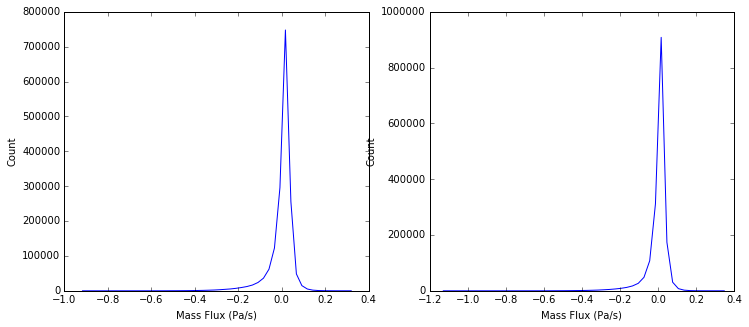

In [21]:
compset = compset_SPCAM
experiment = experiment_PI
casename = "bf_%s_%s"%(compset,experiment)
subset = subset_all

# indir = os.path.join(inputdir,casename,'day')
indir = os.path.join(os.path.dirname(currentpath),'results/day')
print indir

fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(12,5))

# mf = getVar('MF',os.path.join(inputdir,casename,'day'))[:]
mfs = [getVar('MF',indir,inputfiles=['MF_day_CESM111-SPCAM20_piControl_r1i1p1_18500501-18510430.nc'])[:],
       getVar('MF',indir,inputfiles=['MF_day_CESM111-SPCAM20_abrupt4xCO2_r1i1p1_18500501-18510430.nc'])[:]]

for i in range(2):
    
    mf = mfs[i]
    mf_H, mf_e = np.histogram(mf.ravel(),bins=50)
    mf_c = (mf_e[1:]+mf_e[:-1])/2

    ax[i].plot(mf_c,mf_H)
    ax[i].set_xlabel('Mass Flux (Pa/s)')
    ax[i].set_ylabel('Count')

    ## Show statistics
    mf_max = 0.015
    mf_zero = mf.copy()
    mf_zero[mf < -mf_max] = np.nan
    mf_zero[mf > mf_max] = np.nan
    print "Mass flux standard deviation:", np.std(mf)
    print "Tropical mean mass flux:", np.mean(mf)
    print "Mass flux mode:", mf_c[np.argmax(mf_H == mf_H.max())]
    print np.logical_not(np.isnan(mf_zero)).sum()

plt.show()



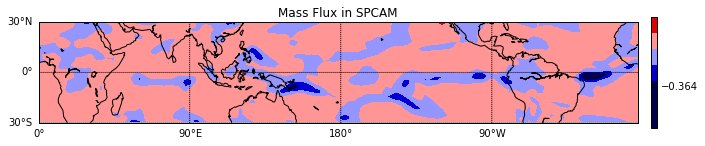

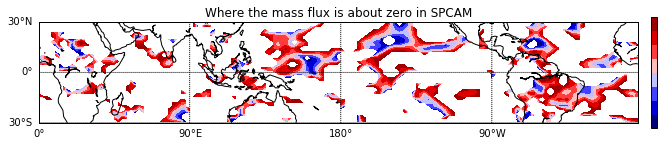

In [23]:
vmax = min(mf.max(),-mf.min())

fig = plt.figure(figsize=(12,2))
map = Basemap(projection='cyl',lat_0=0,lon_0=180,llcrnrlon=0,llcrnrlat=-30,urcrnrlon=357,urcrnrlat=30)
levs = np.arange(-vmax,vmax,30)
# map.contourf(lon2D,lat2D,mf,levels=levs,cmap=plt.cm.Blues,norm = LogNorm())
map.contourf(lon2D,lat2D,mf[0],cmap=plt.cm.seismic,vmin=-vmax,vmax=vmax)
map.drawparallels(range(-90, 100, 30),labels=[1,0,0,1])
map.drawmeridians(range(0,400,90),labels=[1,0,0,1])
map.drawcoastlines()
plt.title('%s in %s'%('Mass Flux',compset_labels[compset]))
plt.colorbar(ticks=levs,pad=0.02,fraction=0.085)

fig = plt.figure(figsize=(12,2))
map = Basemap(projection='cyl',lat_0=0,lon_0=180,llcrnrlon=0,llcrnrlat=-30,urcrnrlon=357,urcrnrlat=30)
levs = np.arange(mf.min(),mf.max(),10)
# map.contourf(lon2D,lat2D,mf,levels=levs,cmap=plt.cm.Blues,norm = LogNorm())
# map.contourf(lon2D,lat2D,mf_zero[0],cmap=plt.cm.seismic,vmin=-vmax,vmax=vmax)
map.contourf(lon2D,lat2D,mf_zero[0],cmap=plt.cm.seismic)
map.drawparallels(range(-90, 100, 30),labels=[1,0,0,1])
map.drawmeridians(range(0,400,90),labels=[1,0,0,1])
map.drawcoastlines()
plt.title('%s in %s'%('Where the mass flux is about zero',compset_labels[compset]))
plt.colorbar(ticks=levs,pad=0.02,fraction=0.085)
